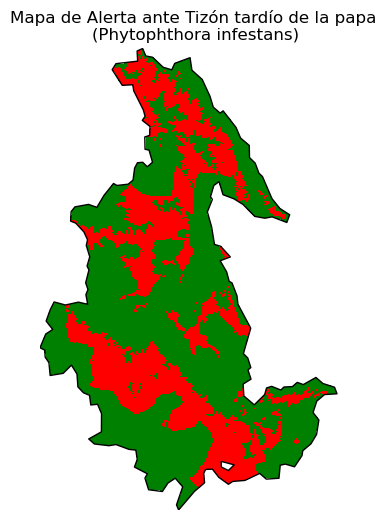

In [7]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from matplotlib.colors import ListedColormap

netcdf_file = r'C:\Users\Jordy\Desktop\AT\t_2mC__2024_10_1__2024_10_7-12_0.nc'
netcdf_file1 = r'C:\Users\Jordy\Desktop\AT\relative_humidity_2mp__2024_10_1__2024_10_7-12_0.nc'
ds = xr.open_dataset(netcdf_file)
ds1 = xr.open_dataset(netcdf_file1)

#Papa;Phytophthora infestans;1;10;15;75;90;Tizón tardío de la papa
intervalo_dias = 1
Tmin,Tmax = 10, 15
RHmin, RHmax = 75, 90

T2m_total = ds['t_2m']
T2m_diario = T2m_total.resample(time='1D').mean()
rh_total = ds1['relative_humidity_2m']
rh_diario = rh_total.resample(time='1D').mean()

condicion_t2m = (T2m_diario > Tmin) & (T2m_diario < Tmax)
condicion_rh = (rh_diario > RHmin) & (rh_diario < RHmax)

#Almacenar el resultado para un solo día (sin 3 días consecutivos)
dias_cumplen_t2m = np.any(condicion_t2m, axis=0)  # True si se cumple en al menos un día
dias_cumplen_rh = np.any(condicion_rh, axis=0)    # True si se cumple en al menos un día

dias_cumplen = dias_cumplen_t2m & dias_cumplen_rh  # Intersección de las dos condiciones

ruta_geojson = r'C:\Users\Jordy\Desktop\AT\peru_departamental_simple.geojson'
data = gpd.read_file(ruta_geojson)
ayacucho = data[data['NOMBDEP'] == 'AYACUCHO']

long = ds.coords['longitude'].values
lat = ds.coords['latitude'].values

# Crear un grid de puntos a partir de las coordenadas de latitud y longitud
lon_grid, lat_grid = np.meshgrid(long, lat)

# Crear una lista de puntos a partir de las coordenadas de latitud y longitud
puntos = [Point(lon, lat) for lon, lat in zip(lon_grid.flatten(), lat_grid.flatten())]

# Crear un GeoDataFrame de estos puntos
gdf_puntos = gpd.GeoDataFrame(geometry=puntos, crs=ayacucho.crs)

# Filtrar los puntos que están dentro de la geometría de Ayacucho
puntos_dentro = gdf_puntos.within(ayacucho.unary_union)

# Redimensionar la máscara para que coincida con la forma original de los datos
mask = puntos_dentro.values.reshape(lon_grid.shape)

minx, miny, maxx, maxy = ayacucho.total_bounds

dias_cumplen_masked = np.where(mask, dias_cumplen, np.nan)

fig, ax = plt.subplots(figsize=(10, 6))
cmap = ListedColormap(['green', 'red'])
x = np.linspace(minx, maxx, dias_cumplen.shape[1])  # Longitud
y = np.linspace(miny, maxy, dias_cumplen.shape[0])  # Latitud
contorno = ax.contourf(long, lat, dias_cumplen_masked, cmap=cmap, levels=50)
ayacucho.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=1)

titulo_largo = "Mapa de Alerta ante Tizón tardío de la papa \n(Phytophthora infestans)"
ax.set_title(titulo_largo, loc='center', fontsize=12)
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
ax.set_axis_off()

plt.savefig("Mapa de Alerta.png", format='png')
plt.show()